## Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from thefuzz import process

from lib.sb_utils import save_file


## Read Data

In [4]:
college_data1 = pd.read_csv('../raw_data/College_Data.csv')
college_data2 = pd.read_csv('../raw_data/tuition_cost.csv')

In [5]:
college_data1.rename(columns={college_data1.columns[0]:"name"}, inplace=True)
college_data1.drop(["Outstate", "Personal", "Terminal"], axis=1, inplace=True)
print(college_data1.head())
college_data1.shape

                           name Private  Apps  Accept  Enroll  Top10perc  \
0  Abilene Christian University     Yes  1660    1232     721         23   
1            Adelphi University     Yes  2186    1924     512         16   
2                Adrian College     Yes  1428    1097     336         22   
3           Agnes Scott College     Yes   417     349     137         60   
4     Alaska Pacific University     Yes   193     146      55         16   

   Top25perc  F.Undergrad  P.Undergrad  Room.Board  Books  PhD  S.F.Ratio  \
0         52         2885          537        3300    450   70       18.1   
1         29         2683         1227        6450    750   29       12.2   
2         50         1036           99        3750    400   53       12.9   
3         89          510           63        5450    450   92        7.7   
4         44          249          869        4120    800   76       11.9   

   perc.alumni  Expend  Grad.Rate  
0           12    7041         60  
1       

(777, 16)

In [6]:
college_data2 = college_data2[["name","state","degree_length","in_state_tuition", "out_of_state_tuition"]]
print(college_data2.head())
college_data2.shape

                                   name       state degree_length  \
0                Aaniiih Nakoda College     Montana        2 Year   
1          Abilene Christian University       Texas        4 Year   
2  Abraham Baldwin Agricultural College     Georgia        2 Year   
3                       Academy College   Minnesota        2 Year   
4             Academy of Art University  California        4 Year   

   in_state_tuition  out_of_state_tuition  
0              2380                  2380  
1             34850                 34850  
2              4128                 12550  
3             17661                 17661  
4             27810                 27810  


(2973, 5)

## Combine Data

In [7]:
#Change college_data2 to have matching names with college_data1
def match_names(name, choices):
    match, score = process.extractOne(name, choices)
    return match if score >= 80 else None

left_names = college_data1["name"].tolist()
college_data2["name"] = college_data2["name"].apply(lambda x: match_names(x, left_names))

#Get rid of dup keys
dup_keys = college_data2.loc[college_data2.duplicated(subset=["name"], keep=False), "name"].unique()
college_data1 = college_data1[~college_data1["name"].isin(dup_keys)]
college_data1.reset_index(drop=True, inplace=True)


In [8]:
college_data = college_data1.merge(college_data2, how="left", on="name")
college_data.dropna(inplace=True)
college_data.reset_index(drop=True, inplace=True)
print(college_data.head())
college_data.shape

                            name Private  Apps  Accept  Enroll  Top10perc  \
0      Alaska Pacific University     Yes   193     146      55         16   
1               Albright College     Yes  1038     839     227         30   
2                Amherst College     Yes  4302     992     418         83   
3  Auburn University-Main Campus      No  7548    6791    3070         25   
4              Augustana College     Yes   761     725     306         21   

   Top25perc  F.Undergrad  P.Undergrad  Room.Board  Books  PhD  S.F.Ratio  \
0         44          249          869        4120    800   76       11.9   
1         63          973          306        4400    300   79       11.3   
2         96         1593            5        5300    660   93        8.4   
3         57        16262         1716        3933    600   85       16.7   
4         58         1337          300        3244    600   66       10.4   

   perc.alumni  Expend  Grad.Rate          state degree_length  \
0       

(349, 20)

In [9]:
#missing values count
missing = pd.concat([college_data.isnull().sum(), 100 * college_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
name,0,0.0
degree_length,0,0.0
state,0,0.0
Grad.Rate,0,0.0
Expend,0,0.0
perc.alumni,0,0.0
S.F.Ratio,0,0.0
PhD,0,0.0
Books,0,0.0
Room.Board,0,0.0


In [10]:
#College of interest
college_data[college_data.name == 'Purdue University at West Lafayette'].T


,198
name,Purdue University at West Lafayette
Private,No
Apps,21804
Accept,18744
Enroll,5874
Top10perc,29
Top25perc,60
F.Undergrad,26213
P.Undergrad,4065
Room.Board,3990


## Dtypes

In [11]:
#Change object features
college_data.select_dtypes('object')

,name,Private,state,degree_length
0,Alaska Pacific University,Yes,Alaska,4 Year
1,Albright College,Yes,Pennsylvania,4 Year
2,Amherst College,Yes,Massachusetts,4 Year
3,Auburn University-Main Campus,No,Alabama,4 Year
4,Augustana College,Yes,Illinois,4 Year
...,...,...,...,...
344,Wisconsin Lutheran College,Yes,Wisconsin,4 Year
345,Wittenberg University,Yes,Ohio,4 Year
346,Wofford College,Yes,South Carolina,4 Year
347,Worcester Polytechnic Institute,Yes,Massachusetts,4 Year


In [12]:
#Change dtypes
college_data["Private"] = college_data["Private"].map({"Yes": 1, "No": 0})
college_data["degree_length"] = college_data["degree_length"].apply(str).str.extract(r"(\d+)").astype(int)
college_data["state"] = college_data["state"].astype(str)

college_data.dtypes

name                     object
Private                   int64
Apps                      int64
Accept                    int64
Enroll                    int64
Top10perc                 int64
Top25perc                 int64
F.Undergrad               int64
P.Undergrad               int64
Room.Board                int64
Books                     int64
PhD                       int64
S.F.Ratio               float64
perc.alumni               int64
Expend                    int64
Grad.Rate                 int64
state                    object
degree_length             int64
in_state_tuition        float64
out_of_state_tuition    float64
dtype: object

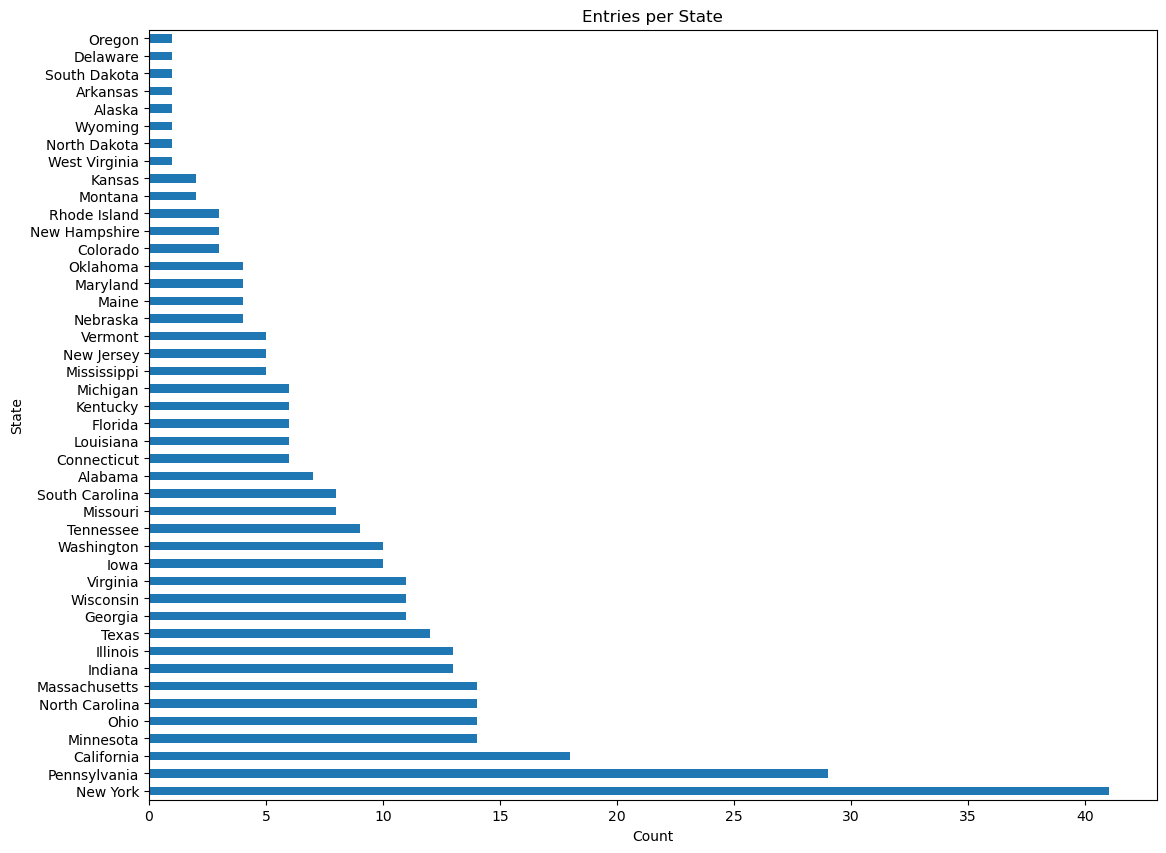

Number of unique states:  44


In [13]:
# Show entries per state
plt.figure(figsize=(13, 10))
college_data.state.value_counts().plot(kind='barh')
plt.title('Entries per State')
plt.xlabel('Count')
plt.ylabel('State')
plt.show()
print("Number of unique states: ", college_data.state.nunique())

In [14]:
# tuition average per state
college_data_state = college_data.groupby('state')[['in_state_tuition', 'out_of_state_tuition']].mean()
college_data_state.head()

,in_state_tuition,out_of_state_tuition
state,,
Alabama,18206.571429,22816.285714
Alaska,20830.000000,20830.000000
Arkansas,26790.000000,26790.000000
California,45170.611111,46781.277778
Colorado,24765.333333,32213.333333


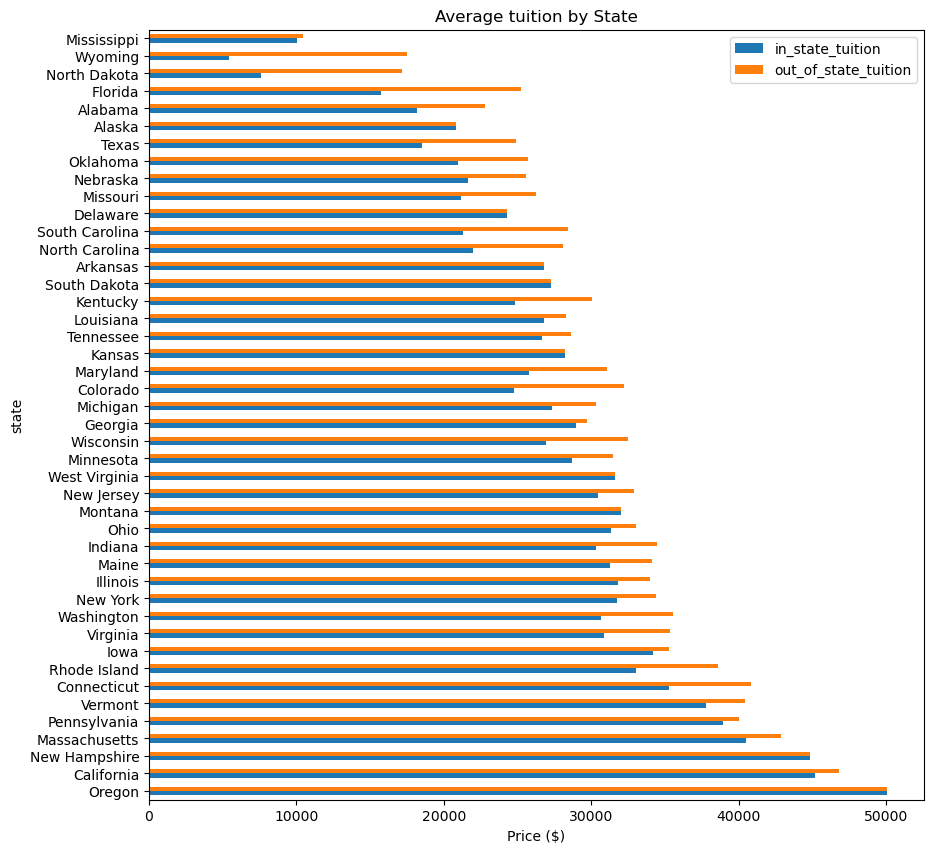

In [15]:
# graph tuition average per state
(college_data_state.reindex(index=college_data_state.mean(axis=1)
    .sort_values(ascending=False)
    .index)
    .plot(kind='barh', figsize=(10, 10), title='Average tuition by State'))
plt.xlabel('Price ($)');

In [16]:
college_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Private,349.0,0.739255,0.439671,0.0,0.0,1.0,1.0,1.0
Apps,349.0,2819.286533,3217.074812,81.0,833.0,1616.0,3579.0,21804.0
Accept,349.0,1940.510029,2202.492650,72.0,664.0,1228.0,2392.0,18744.0
Enroll,349.0,737.498567,892.705318,51.0,266.0,437.0,781.0,5874.0
Top10perc,349.0,27.925501,17.746301,1.0,16.0,25.0,36.0,96.0
Top25perc,349.0,56.478510,19.805889,13.0,40.0,55.0,70.0,100.0
F.Undergrad,349.0,3430.409742,4538.025048,139.0,1000.0,1698.0,3598.0,30017.0
P.Undergrad,349.0,793.406877,1622.958702,1.0,83.0,306.0,847.0,21836.0
Room.Board,349.0,4386.613181,1085.997040,1920.0,3620.0,4240.0,5140.0,7350.0
Books,349.0,549.638968,164.101389,110.0,480.0,500.0,600.0,2000.0


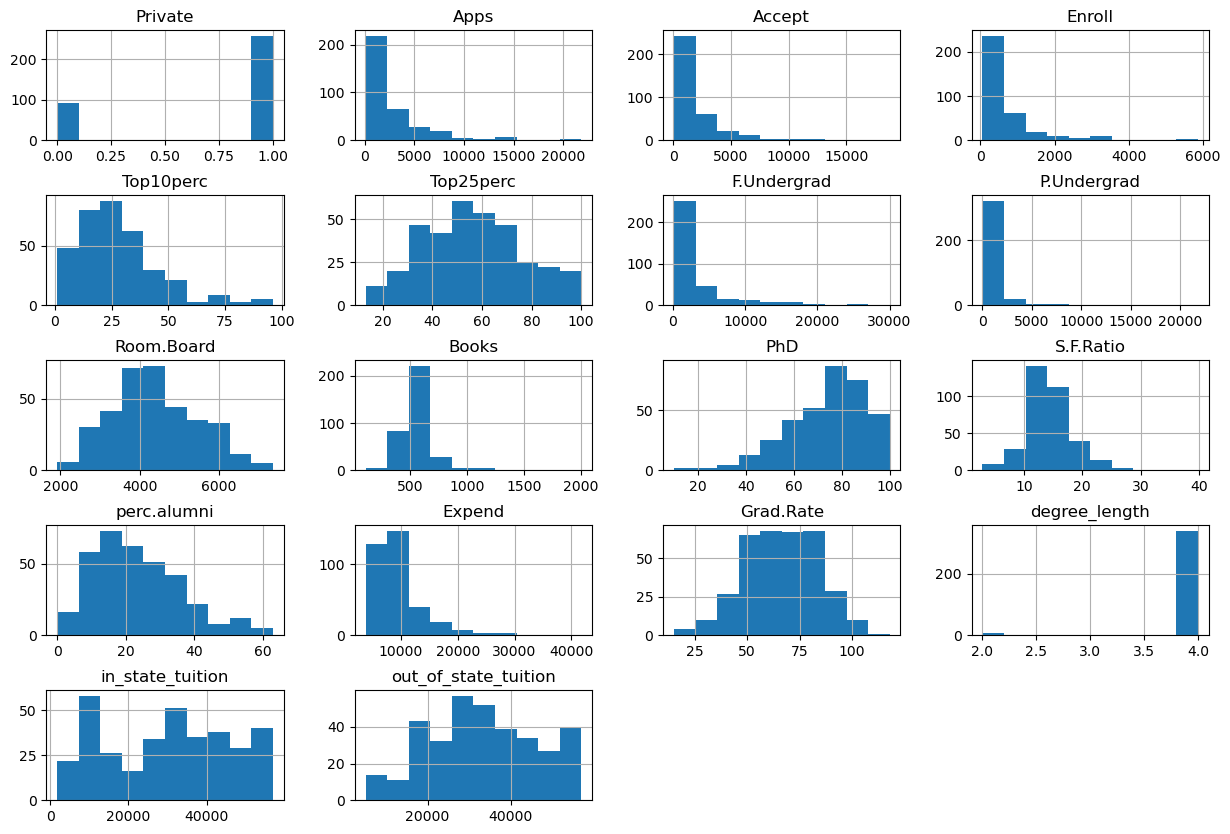

In [17]:
college_data.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

## Target Feature

In [18]:
college_data.drop(columns='in_state_tuition', inplace=True)

In [19]:
college_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  349 non-null    object 
 1   Private               349 non-null    int64  
 2   Apps                  349 non-null    int64  
 3   Accept                349 non-null    int64  
 4   Enroll                349 non-null    int64  
 5   Top10perc             349 non-null    int64  
 6   Top25perc             349 non-null    int64  
 7   F.Undergrad           349 non-null    int64  
 8   P.Undergrad           349 non-null    int64  
 9   Room.Board            349 non-null    int64  
 10  Books                 349 non-null    int64  
 11  PhD                   349 non-null    int64  
 12  S.F.Ratio             349 non-null    float64
 13  perc.alumni           349 non-null    int64  
 14  Expend                349 non-null    int64  
 15  Grad.Rate             3

## Save data

In [20]:
save_file(college_data, 'college_data_cleaned.csv', '../data')

Writing file.  "../data/college_data_cleaned.csv"
